In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
import glob
import os

## import data

In [2]:
# base = "/Users/ivankoh/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/1D/NUS Y3S1/BT4222/Data"
# train_path = max(glob.glob(base + '/train/*.csv'), key=os.path.getctime) 
# print(train_path)
# df = pd.read_csv(train_path)
# X_train, y_train = df.drop('state', axis=1), df['state']

# test_path = max(glob.glob(base + '/test/*.csv'), key=os.path.getctime) 
# print(test_path)
# test = pd.read_csv(test_path)

# X_test, y_test = test.drop('state', axis=1), test['state']

In [3]:
train_path = max(glob.glob('./data/train/*.csv'), key=os.path.getctime) 
test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)

X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24756, 579)
(4369, 579)
(24756, 578)
(24756,)
(4369, 578)
(4369,)


## best classifiers 

In [4]:
#SVC 
svc_best = {'kernel': 'linear', 'gamma': 0.1, 'C': 0.001, 'probability':True}
svc_clf = SVC(**svc_best)
svc_clf.fit(X_train, y_train)

#LOGISTIC REGRESSION
lr_clf = LogisticRegression(max_iter=25000, C= 4.207230251572931, penalty= 'l2', solver= 'lbfgs')
lr_clf.fit(X_train, y_train)

#RANDOM FOREST
rf_best = {'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': False}
rf_clf = RandomForestClassifier(**rf_best)
rf_clf.fit(X_train, y_train)

#XGBOOST 
xgb_clf = xgb.XGBClassifier(n_estimators= 150, max_depth = 5, learning_rate = 0.1)
xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
#VOTING
estimators = [('rf', rf_clf), ('xgb', xgb_clf), ('logreg', lr_clf)]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

#STACKING
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=8,
                                                       min_samples_leaf=4,
                                                       n_estimators=150)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                

## NB

In [6]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
binary_cols = ['staff_pick', 'has_video']
train_numeric = X_train1.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test1.select_dtypes(include='number').drop(binary_cols, axis=1) 

for i, col in enumerate(train_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], 5, retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)
    
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_train1_fitted = imp.fit_transform(X_train1_fitted)
X_test1_fitted = imp.transform(X_test1_fitted)

model_C = CategoricalNB(alpha=1.873817422860387e-09)
clf_C = model_C.fit(X_train1_fitted, y_train)
y_pred = model_C.predict(X_test1_fitted)

C:\Users\radellng\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


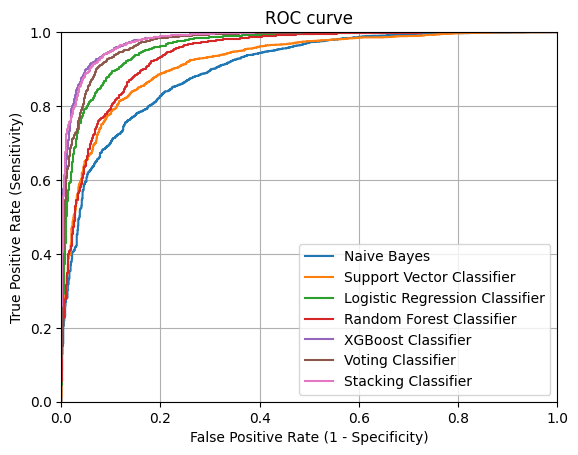

In [9]:
y_pred_prob1 = model_C.predict_proba(X_test1_fitted)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = svc_clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = lr_clf.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = rf_clf.predict_proba(X_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
y_pred_prob5 = xgb_clf.predict_proba(X_test)[:, 1]
fpr5, tpr5, thresholds = roc_curve(y_test, y_pred_prob5)
y_pred_prob6 = voting_clf.predict_proba(X_test)[:, 1]
fpr6, tpr6, thresholds = roc_curve(y_test, y_pred_prob6)
y_pred_prob7 = stacking_clf.predict_proba(X_test)[:, 1]
fpr7, tpr7, thresholds = roc_curve(y_test, y_pred_prob7)

plt.plot(fpr1, tpr1, label = "Naive Bayes")
plt.plot(fpr2, tpr2, label ="Support Vector Classifier")
plt.plot(fpr3, tpr3, label = "Logistic Regression Classifier")
plt.plot(fpr4, tpr4, label ="Random Forest Classifier")
plt.plot(fpr5, tpr5, label ="XGBoost Classifier")
plt.plot(fpr6, tpr6, label ="Voting Classifier")
plt.plot(fpr7, tpr7, label ="Stacking Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)